# SARAO Epidemiological Model

Objective

The objective of the model is to estimate the upper and lower bounds for total demand for hospitalization and ventilator to aid with production planning for the National Ventilator Project executed by SARAO.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy import stats

import warnings

### SEIR-model
We use a class of what is known as compartmental models in which individuals in a population are divided into different compartments depending on predetermined epidemiological properties. Within each compartment, individuals are assumed to have the same characteristics and act in the same way. These are mean-field models, tracking spatially averaged population qualities as they vary over time, with individuals assumed to be homogenous within compartments. The compartments are denoted S as in susceptible, E as in exposed, I as in infected, H as in hospitalised, C as in critical and potentially requiring ICU facility, R as in recovered, and D as in deceased.

When a healthy individual gets infected, he or she does not become infectious at once but enters the symptom-free phase E and remains in that compartment for an average incubation time or latency period, t_inc = 1/sigma.
We divide infectious cases into two groups: reported cases and unreported cases. After the incubation period, an infected individual either is tested through the public or private health care sector and becomes a confirmed and reported case or remains unconfirmed, i.e. an unreported case.

The average time during which an infected individual is infectious is t_inf.

We assume a closed population, which is justified under a model of the rapid spread of a pathogen; that is, we neglect births, and deaths due to other causes in our modeled population. We denote the number of individuals in each compartment by S, E, I_r, I_u, H, C, R, and D, the sum of which is the population size, N.

## Transmission Dynamics

In [2]:
# Susceptible
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S

# Exposed
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)

# Infected
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)

# Hospitalized 
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal):
    return ((1 - frac_mild_total) * (I / t_inf)) + ((1 - frac_fatal) * C / t_crit) - (H / t_hosp)

# Critical
def dC_dt(H, C, t_hosp, t_crit, frac_crit):
    return (frac_crit * H / t_hosp) - (C/t_crit)
    # return (frac_crit * H / t_hosp) - (1-frac_fatal)*(C/t_crit) - frac_fatal*(C/t_crit)
    # i.e.  = (term gained from Hospitalised) - (term lost to Hospitalised) - (term lost to Deaths)
    #       = (term gained from H) - (terms lost to both H and D)

# Recovered
def dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit):
    return (frac_mild_total * I / t_inf) + (1 - frac_crit) * (H / t_hosp)

# Deaths
def dD_dt(C, t_crit, frac_fatal):
    return frac_fatal * (C/t_crit)


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=6.1, t_hosp=4, t_crit=10, frac_mild_total=0.96, frac_crit=0.2, frac_fatal=0.2):
    """
    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Time-varying reproductive number
    :param t_inc: Average incubation period. 
    :param t_inf: Average infectious period. 
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical.
    :param t_crit: Average time a patient is in a critical state (either recovers or dies).
    :param frac_mild_total: Fraction of infections that are asymptomatic or mild.      
    :param frac_crit: Fraction of severe cases that turn critical.                      
    :param frac_fatal: Fraction of critical cases that are fatal.                   
    :return:
    """
    
    # account for potential functional nature of R_t
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t

    S, E, I, R, H, C, D = y
    
    # account for ICU overload by modifying the fatality ratio
    ICU_CAPACITY = 4000/N # [find ref please]
    #TURN OFF
    #if C > ICU_CAPACITY:
      #[again, can we get true number of ICU Overflow fatality and ref from Willem/Fernando?]
      #frac_fatal = ((C - ICU_CAPACITY)/C)*np.minimum(0.8, np.random.normal(0.6, 0.15)) + (ICU_CAPACITY/C)*frac_fatal
      #frac_fatal = ((C - ICU_CAPACITY)/C)*0.8 + (ICU_CAPACITY/C)*frac_fatal
      #frac_fatal = (patients needing ICU who can't get it)*(higher fatality rate) + (patients needing ICU who can get it)*(fiducial fatality rate)
    
    # account for effect of increased deaths: i. extra lockdown by goverment ii. greater compliance with social distancing measures
    def find_idx_nearest(array, value):
      array = np.asarray(array)
      idx = (np.abs(array - value)).argmin()
      return idx # array[idx], idx

    dn = np.linspace(1e+03, 2.5e+05, 100)
    rn = np.linspace(3, 1.3, 100)
    rtcap = rn[find_idx_nearest(dn, D)]
    #TURN OFF
    #reprod = np.minimum(rtcap, reprod)

    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal)
    C_out = dC_dt(H, C, t_hosp, t_crit, frac_crit)
    D_out = dD_dt(C, t_crit, frac_fatal)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

## Plotting Functions

In [3]:
def plot_ensemble(N, scenarios, title='SARAO SIER-HCD Model'):
    # set up the axes, titles, styles, etc
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
    fig.suptitle(title, fontsize=16)
    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Cumulative Total Cases"))
    
    ax3.set_xlabel("Days", fontsize=10);
    ax4.set_xlabel("Days", fontsize=10);
    
    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=10, ymax=N*1.2)
        axis.set_xlim(0, model_days)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=model_days, linestyles='dotted', alpha = 0.6);
    
    #ax4.set_ylim(.001, 1.2)
    #ax4.set_xlim(0, model_days)
    
    # loop over each scenario in the ensemble and plot to the axes
    for idx, solution in enumerate(scenarios):
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = (inf + rec + hosp + crit + death)
        ax1.plot(crit*N, 'tab:red', label='Critical', alpha=0.05);
        ax2.plot(death*N, 'tab:grey', label='Fatalities', alpha=0.05);
        ax3.plot(hosp*N, 'tab:orange', label='Hospitalised', alpha=0.05);
        ax4.plot(cases*N, 'tab:blue', label='Total cases', alpha=0.1);
    
    #plot stars
    #x_20May = 19 #zero-indexed!
    #deaths_20May = 339
    #cases_20May=18003
    #ax2.scatter(x_20May, deaths_20May, s=40, marker=(5, 2), color = 'r', alpha=1)
    #ax4.scatter(x_20May, cases_20May, s=40, marker=(5, 2), color = 'k', alpha=1)

    #plot measured cases and deaths from Worldometer
    cases = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,7,7,13,16,24,38,61,64,85,116,150,202,240,274,402,554,709,927,1170,1187,1280,1326,1353,1380,1462,1505,1585,1655,1686,1749,1845,1934,2003,2028,2173,2272,2415,2506,2605,2783,3034,3158,3300,3465,3635,3953,4220,4361,4546,4793,4996,5350,5647,5951,6336,6783,7220,7572,7808,8232,8895,9420,10015,10652,11350,12074,12739,13524,14355,15515,16433,17200,18003])
    deaths = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,5,5,5,9,9,11,12,13,18,18,24,25,25,27,27,34,48,50,52,54,58,58,65,75,79,86,87,90,93,103,103,116,123,131,138,148,153,161,178,186,194,206,206,219,238,247,261,264,286,312,339])
    dates = np.array(["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20"])
    ax4.semilogy(cases[76:])
    ax2.semilogy(deaths[76:])

In [4]:
def plot_hist(comp, title="Histogram and KDE through scenario ensemble", days = [31,61,122,153]):
  # plot histogram for specified compartment on various key dates
  # set up the axes, titles, styles, etc
  fig, axes = plt.subplots(2, 2, figsize=(8,6))
  ((ax1, ax2), (ax3, ax4)) = axes
  fig.suptitle(title, fontsize=14)
  ax1.set_title("1 June")
  ax2.set_title("1 July")
  ax3.set_title("1 September")
  ax4.set_title("Maximum")
  plt.tight_layout()

  # set uniform characteristics for axes
  for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
    axis.set_yscale('log')
    axis.set_xscale("log")
    axis.tick_params(axis='y', labelsize=12);

    if idx == 3:
      hist_data = N*comp.max(1)
    else:
      hist_data = N*comp[:,int(days[idx])]
    
    ax1.set_ylabel("density", fontsize=10);
    #ax3.set_ylabel("density", fontsize=10);
        
    MAX=np.max(hist_data)
    MIN=np.min(hist_data)
    bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
    x_d = np.linspace(MIN, MAX, hist_data.shape[0])

    axis.hist(hist_data, bins=bins, density=True, histtype='step', color='k')#, alpha=0.5, log=True)

    #percentiles
    axis.axvline(np.percentile(hist_data, 50), color='k', linestyle='dotted', alpha=0.5) #ax2.axvline(np.median(h_data), color='g')
    axis.axvline(np.percentile(hist_data, 95), color='k', linestyle='dotted', alpha=0.5)
    axis.axvline(np.percentile(hist_data, 5), color='k', linestyle='dotted', alpha=0.5)

## Model Parameters

In [5]:
# parameters from the Imperial paper (https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

R_0 = 2.4 # basic reproductive number
t_incu = 5.1 # average incubation period
t_infect = 6.1 # average infectious period
t_hosp = 4 # time in hospital before transitioning to either critical or recovered
t_crit = 10 # average time patient is critical before transition to recovered or dead

ratio_mild = 0.80 # ratio of infections that are mild.
ratio_unreported = 0.80 # ratio of total infections that remain unreported due to lack of symptoms #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
#ratio_asymptomatic = 0.96 # ratio of infections that are either mild or unreported, and may be symptomless (potentially bad variable name!)
ratio_severe = 1 - ratio_mild
ratio_crit = 0.20 # ratio of severe cases that become critical
ratio_fatal = 0.40 # ratio of critical cases that result in death

N = 59156682  # Population size
n_tested_active =  4502 #3453 # total cases - recovered: 5951 - 2498
n_total_cases = 5951
n_hosp = 140#??
n_crit = 70#??
n_dead = 116

## Intervention Scenario

### Ensembles

In [6]:
model_days = 240
N_RUNS = 1000

def time_varying_reproduction(t):
    if t <= t_startL5:
        warnings.warn("Using R_0 in time-varying_reproduction function") #throw error/warning
        return R_0
    elif t > t_startL5 and t <= t_startL4:
        return R_t_L5
    elif t > t_startL4 and t <= t_startL3:
        return R_t_L4
    elif t > t_startL3 and t <= t_startL2:
        return R_t_L3
    elif t > t_startL2 and t <= t_startL1:
        return R_t_L2
    elif t > t_startL1:
        return R_t_L1
    else:
        warnings.warn("Using R_0 in time-varying_reproduction function")  #throw error/warning
        return R_0

i_scenarios = []

for i in range(N_RUNS):
  print(i)
  # scenario variables
  R_t_L5 = 1.4*np.random.normal(1.0, 0.03)
  R_t_L4 = np.maximum(0.65, R_t_L5*np.random.normal(1.2, 0.15))
  R_t_L3 = np.maximum(0.65, R_t_L4*np.random.normal(1.0, 0.25))
  R_t_L2 = np.maximum(0.65, R_t_L3*np.random.normal(1.0, 0.25))
  R_t_L1 = np.maximum(0.85, np.random.normal(0.95, 0.35))

  t_startL5 = -1
  t_startL4 = int(np.maximum(21, np.random.normal(30, 7)))
  t_startL3 = int(np.maximum(41, np.random.normal(60, 7)))
  t_startL2 = int(np.random.normal(120, 21))
  t_startL1 = int(np.random.normal(150, 28))

  R_0 = np.maximum(1.8, np.random.normal(2.4, 0.31))
  
  t_incu = np.random.normal(3.96, 0.34) # average incubation period
  t_infect = np.random.normal(5, 2) # average infectious period
  t_hosp = np.random.normal(4, 0.5) # time in hospital before transitioning to either critical or recovered
  t_crit = np.random.normal(10, 2) # average time patient is critical before transition to recovered or dead     # Distribution is possibly lognormal?


  frac_asymptomatic = np.minimum(0.96, np.random.normal(0.65, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
  frac_tested_mild = np.minimum(0.96, np.random.normal(0.80, 0.05)) # ratio of tested infections that are mild. [REF??]
  frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))

  frac_crit = np.maximum(0.05, np.random.normal(0.20, 0.05)) # ratio of severe cases that become critical
  frac_fatal = np.maximum(0.05, np.random.normal(0.20, 0.05))  # ratio of critical cases that result in death

  n_infected = n_tested_active * (1/(1-frac_asymptomatic))
  n_exposed = n_infected * 1.7 #(R_t^(time from infection to test)/t_inf ~ 2)*n_infected
  n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))

  initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]

  args = (time_varying_reproduction, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)

  # run solver and save to solution matrix
  sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
  i_scenarios.append(sol)

plot_ensemble(N, i_scenarios, title = "SARAO SEIR-HCD model - Intervention Scenario Ensemble")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183


KeyboardInterrupt: 

### Histograms

<ipython-input-4-30df8fccdbce>:29: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
/Users/nadeem/py3_kernel/lib/python3.8/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/nadeem/py3_kernel/lib/python3.8/site-packages/numpy/core/function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
/Users/nadeem/py3_kernel/lib/python3.8/site-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
<ipython-input-4-30df8fccdbce>:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis.axvline(np.percentile(hist_data, 50), color='k', linestyle='dotted', alpha=0.5) #ax2.axvline(np.median(h_data), color='g')
<ipython-input-4-30df8fccdbce>:29: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(MIN), np.log10(MAX

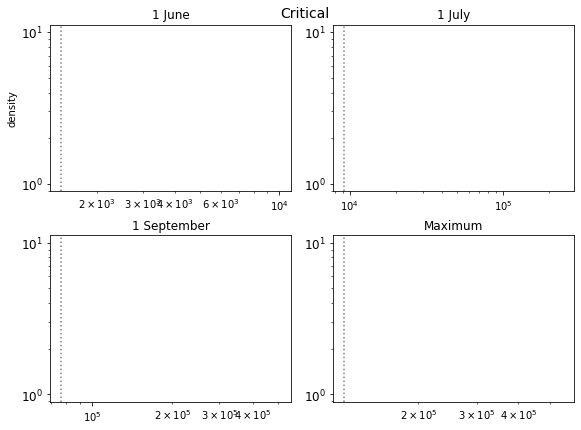

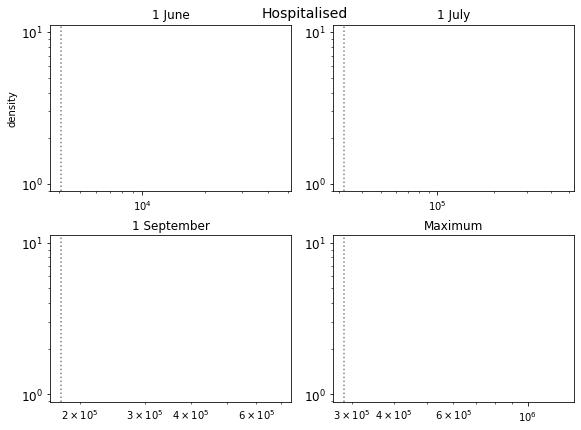

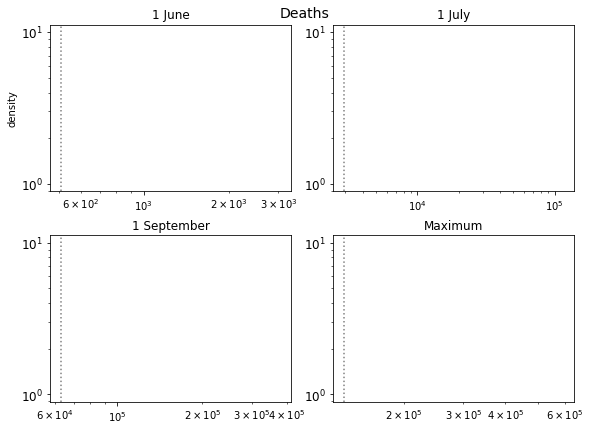

In [7]:
is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]]) # i.e. make it, for instance [1000, 7, 240] 
for idx, sol in enumerate(i_scenarios):
  is_arr[idx,:,:] = sol.y

# days of evaluation should correspond to [1 June, 1 July, 1 September, 1 October]
eval_days = [31,61,122,153]

compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
show_labels = ['Critical', 'Hospitalised', 'Deaths']


for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), compartment_labels.index(show_labels[1]), compartment_labels.index(show_labels[2])],:], 1)):
    plot_hist(scen, title = show_labels[idx], days=eval_days)

# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 

### R_t parameterisation and plots

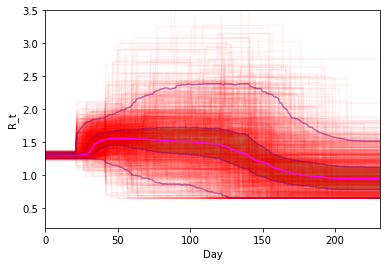

In [8]:
t_arr = np.empty((N_RUNS, model_days))
for i in range(N_RUNS):
  # scenario variables
  R_t_L5 = 1.3*np.random.normal(1.0, 0.02)
  R_t_L4 = np.maximum(0.65, R_t_L5*np.random.normal(1.2, 0.15))
  R_t_L3 = np.maximum(0.65, R_t_L4*np.random.normal(1.0, 0.25))
  R_t_L2 = np.maximum(0.65, R_t_L3*np.random.normal(1.0, 0.25))
  R_t_L1 = np.maximum(0.65, np.random.normal(0.95, 0.35))

  t_startL5 = -1
  t_startL4 = int(np.maximum(21, np.random.normal(30, 7)))
  t_startL3 = int(np.maximum(41, np.random.normal(60, 14)))
  t_startL2 = int(np.random.normal(120, 21))
  t_startL1 = int(np.random.normal(150, 28))

  t = np.empty(model_days)
  for j in range(model_days):
    t[j] = time_varying_reproduction(j)

  plt.plot(t, color='r', alpha=0.05)
  plt.ylabel("R_t")
  plt.xlabel("Day")
  t_arr[i,:] = t

median = np.empty(model_days)
percentile_32 = np.empty(model_days)
percentile_68 = np.empty(model_days)
percentile_5 = np.empty(model_days)
percentile_95 = np.empty(model_days)
for day in range(t_arr.shape[1]):
  median[day] = np.median(t_arr[:,day])
  percentile_32[day] = np.percentile(t_arr[:,day], 32)
  percentile_68[day] = np.percentile(t_arr[:,day], 68)
  percentile_5[day] = np.percentile(t_arr[:,day], 5)
  percentile_95[day] = np.percentile(t_arr[:,day], 95)


plt.ylim(0.2, 3.5)
plt.xlim(0, 231)
plt.plot(range(model_days), median, color = 'magenta')
plt.plot(range(model_days), percentile_32, color='purple', alpha=0.5)
plt.plot(range(model_days), percentile_68, color='purple', alpha=0.5)
plt.plot(range(model_days), percentile_5, color='purple', alpha=0.5)
plt.plot(range(model_days), percentile_95, color='purple', alpha=0.5)
plt.fill_between(range(model_days), percentile_32, percentile_68, facecolor='green', alpha=0.4)

In [0]:
for i in range(10):
  plt.plot(t_arr[np.random.randint(t_arr.shape[0]),:])

# Scratch

In [0]:
#test ICU_Overload code

ratio_fatal=0.2
ICU_CAPACITY = 4000 # [find ref please]   
for C in [-1, 0, 1000, 3999, 4000, 4001, 5000, 10000, 100000, 1e7]:
  # account for ICU overload by modifying the fatality ratio
  if C > ICU_CAPACITY: 
    #[again, can we get true number and ref from Willem/Fernando]
    ratio_fatal = ((C - ICU_CAPACITY)/C)*np.maximum(0.8, np.random.normal(0.6, 0.15)) + ICU_CAPACITY/C*ratio_fatal #0.8 #
  
  print(ratio_fatal)


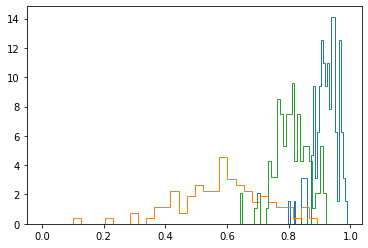

In [0]:
# trying to get the correct distribution for frac_mild_tested

ra=np.empty(N_RUNS)
ru=np.empty(N_RUNS)
rm=np.empty(N_RUNS)
for i in range(N_RUNS):
  frac_asymptomatic = np.minimum(0.96, np.random.normal(0.60, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
  frac_tested_mild = np.minimum(0.96, np.random.normal(0.80, 0.05)) # ratio of infections that are mild. 
  frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))
  ra[i] = frac_mild_total
  ru[i] = frac_asymptomatic
  rm[i] = frac_tested_mild
plt.hist(ra, bins=30, density=True,histtype='step')
plt.hist(ru, bins=30, density=True,histtype='step')
plt.hist(rm, bins=30, density=True,histtype='step')
k=stats.gaussian_kde(ra, bw_method=30)
plt.plot(range(0,1,30), k(range(0,1,30)))
ra.shape

symptomatic_frac = 0.5    # Vo, Diamond Princess 
symptomatic_frac_tested = 0.1#??   # Country specific 
# IFR = 1% = dead(t)/counts(t-14)

mild_frac_of_cases = 0.8  #CFR 
fraction_tested = (symptomatic_frac)*symptomatic_frac_tested*mild_frac_of_cases
